<center> <h1><bold>
<hr style="border-width:2px;border-color:#1664c8">
Exploration des fichiers <b>"small_vocab_en"</b> et <b>"small_vocab_fr"</b><br>
et 6eme version de traduction mot à mot,<br>
en mode non supervisé et supervisé
<hr style="border-width:2px;border-color:#1664c8">
</center> </h1></bold>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

> **Importation des bibliothèques :**

In [2]:
%matplotlib inline
import os
import time
import random
import contextlib
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from gensim import corpora
from sacrebleu import sentence_bleu, corpus_bleu

import warnings
warnings.filterwarnings('ignore')

> **Choix des options d'execution (en fonction du temps disponible)**

In [3]:
# Indiquer si l'on veut enlever les stop words. C'est un processus long
stopwords_to_do = True
# Indiquer si l'on veut lemmatiser les phrases, un fois les stop words enlevés. C'est un processus long (approximativement 8 minutes)
lemmatize_to_do = True
# Indiquer si l'on veut calculer le score Bleu pour tout le corpus. C'est un processus très long long (approximativement 10 minutes pour les 10 dictionnaires)
bleu_score_to_do = True

> **Définition d'une fonction pour lire les fichiers small_vocab en anglais et en français, et conversion en minuscules :**

In [4]:
def load_data(path):

    # Nombre maximum de lignes à renvoyer
    max_lines = 140000
    
    input_file = os.path.join(path)
    with open(input_file, "r",  encoding="utf-8") as f:
        data = f.read()
        
    # On convertit les majuscules en minulcule
    data = data.lower()
    
    data = data.split('\n')
    return data[:min(len(data),max_lines)]

> **Définition d'une fonction de nettoyage des phrases non traduites, i.e. identiques dans les 2 langues**

In [5]:
def clean_untranslated_sentence(data1, data2):
    i=0
    while i<len(data1):
        if data1[i]==data2[i]:
            data1.pop(i)
            data2.pop(i)
        else: i+=1
    return data1,data2

> **Correction des fautes d'orthographe**
>
> Les données textuelles telles que les textes des médias sociaux contiennent parfois des fautes d'orthographe. Elles doivent être rectifiées dès le début de la phase de nettoyage. Heureusement, nous disposons de bibliothèques pour corriger l'orthographe.

In [6]:
from spellchecker import SpellChecker

def correct_spellings(text, l):

    spell = SpellChecker(language=l)
    corrected_words = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            cw = (spell.correction(word))
            if not cw:
                cw=word
            else:
                corrected_words.append(spell.correction(word))
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

text = "Spelling correctin is proprly perfrmed"
text = correct_spellings(text,'en')
print(text)
text = "Correction d' ecritur est corretement réalisée"
text = correct_spellings(text,'fr')
print(text)

Spelling correcting is properly performed
Correction de écriture est correctement réalisée


> **Elimination des mots indésirable et des mots transparents** (non porteur de sens)
>
> Les textes contiennent de nombreux éléments qui ne sont pas utiles pour le traitement de texte et il est préférable de les éliminer avant la modélisation. 

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
with contextlib.redirect_stdout(open(os.devnull, "w")):
    nltk.download('stopwords')
    
def remove_stopwords(text, lang): 
    stop_words = set(stopwords.words(lang))
    # stop_words will contain  set all english stopwords
    filtered_sentence = []   
    for word in text.split(): 
        if word not in stop_words: 
            filtered_sentence.append(word) 
    return " ".join(filtered_sentence)

def clean_undesirable_from_text(sentence, lang):

    # Removing URLs 
    sentence  = re.sub(r"https?://\S+|www\.\S+", "", sentence )
    
    # Removing Punctuations (we keep the . character)
    REPLACEMENTS = [("..", "."),
                    (",", ""),
                    (";", ""),
                    (":", ""),
                    ("?", ""),
                    ('"', ""),
                    ("-", " "),
                    ("it's", "it is"),
                    ("isn't","is not"),
                    ("'", " ")
                   ]
    for old, new in REPLACEMENTS:
        sentence = sentence.replace(old, new)
    
    # Removing Digits
    sentence= re.sub(r'[0-9]','',sentence)
    
    # Removing Additional Spaces
    sentence = re.sub(' +', ' ', sentence)

    return sentence

# clean_undesirable_from_text("Hello     , Do you like the:;:?' 45678 this is True https://www.google.com/search?client=firefox-b-d&q=pyspellchecker .", 'english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olivi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


> **Définition d'un fonction de lemmatisation**

In [8]:
import spacy
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')

def lemmatize(sentence,lang):
    # Create a Doc object
    if lang=='en':
        nlp=nlp_en
    elif lang=='fr':
        nlp=nlp_fr
    else: return
    doc = nlp(sentence)

    # Create list of tokens from given string
    tokens = [] 
    for token in doc:
        tokens.append(token)

    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
 
    return lemmatized_sentence

# s= 'the bats saw the cats with best stripes hanging upside down by their feet'
# print(s)
# print(lemmatize(s,'en'))
# s ="les chauves souris ont vu les chats avec les meilleures rayures suspendus a l'envers par les pieds"
# print(s)
# print(lemmatize(s,'fr'))

> **Préprocessing du texte pour pouvoir l'analyser**
>> **(a)** Elimination de la ponctuation, des url, des chiffres
>>
>> **(b)** Elimination des pmots transparent
>>
>> **(c)** Splitage du texte en mots
>>
>> **(d)** Lemmatisation
>>
>> **(e)** Définition du corpus de mots utilisé
>>
>> **(f)** Comptage, dans chaque phrase, du nombre de mots uniques qui se trouvent dans le corpus

In [9]:
import time

###
### Définition de la fonction preprocess_txt
###

def preprocess_txt (data, lang):
    
    word_count = collections.Counter()
    word_lem_count = collections.Counter()
    word_wosw_count = collections.Counter()
    corpus = []
    data_split = []
    sentence_length = []
    data_split_wo_stopwords = []
    data_length_wo_stopwords = []
    data_lem = []
    data_lem_length = []
    
    txt_en_one_string= ". ".join([s for s in data])
    txt_en_one_string = txt_en_one_string.replace('..', '.')
    txt_en_one_string = " "+clean_undesirable_from_text(txt_en_one_string, 'lang')
    data = txt_en_one_string.split('.')
    if data[-1]=="":
        data.pop(-1)
    for i in range(len(data)): # On enleve les ' ' qui commencent et finissent les phrases 
        if data[i][0] == ' ':
            data[i]=data[i][1:]
        if data[i][-1] == ' ':
            data[i]=data[i][:-1]
    nb_phrases = len(data)
    
    # Création d'un tableau de mots (sentence_split)
    for i,sentence in enumerate(data):
        sentence_split = word_tokenize(sentence)
        word_count.update(sentence_split)
        data_split.append(sentence_split)
        sentence_length.append(len(sentence_split))

    # La lemmatisation et le nettoyage des stopword va se faire en batch pour des raisons de vitesse
    # (au lieu de le faire phrase par phrase)
    # Ces 2 processus nécéssitent de connaitre la langue du corpus
    if lang == 'en': l='english'
    elif lang=='fr': l='french'
    else: l="unknown"

    if l!="unknown":
        # Lemmatisation en 12 lots (On ne peut lemmatiser + de 1 M de caractères à la fois)
        if lemmatize_to_do:
            n_batch = 12
            batch_size = round((nb_phrases/ n_batch)+0.5)
            data_lemmatized=""
            avancement = "."*n_batch
            print('Lemmatisation: ['+avancement+']',end="\r")
            for i in range(n_batch):
                print('Lemmatisation: ['+avancement+']',end="\r")
                to_lem = ".".join([s for s in data[i*batch_size:(i+1)*batch_size]])
                data_lemmatized = data_lemmatized+"."+lemmatize(to_lem,lang).lower()
                avancement = "="*(i+1) + "."*(n_batch-(i+1))
                print('Lemmatisation: ['+avancement+']',end="\r")

            data_lem_for_sw = data_lemmatized[1:]  
            data_lemmatized = data_lem_for_sw.split('.')
            for i in range(nb_phrases):
                data_lem.append(data_lemmatized[i].split())
                data_lem_length.append(len(data_lemmatized[i].split()))
                word_lem_count.update(data_lem[-1])
                               
        # Elimination des StopWords en un lot
        # On élimine les Stopwords des phrases lémmatisés, si cette phase a eu lieu
        # (wosw signifie "WithOut Stop Words")
        if stopwords_to_do:
            if lemmatize_to_do:
                data_wosw = remove_stopwords(data_lem_for_sw,l)
            else:
                data_wosw = remove_stopwords(txt_en_one_string,l)
                               
            data_wosw = data_wosw.split('.')
            for i in range(nb_phrases):
                data_split_wo_stopwords.append(data_wosw[i].split())
                data_length_wo_stopwords.append(len(data_wosw[i].split()))
                word_wosw_count.update(data_split_wo_stopwords[-1])

    corpus = list(word_count.keys())
    nb_mots = sum(word_count.values())
    nb_mots_uniques = len(corpus)


    # Affichage du nombre de mot en fonction du pré-processing réalisé   
    print("Nombre de phrases                     : ",nb_phrases)
    print("Nombre de mots                        : ",nb_mots)
    print("Nombre de mots uniques                : ",nb_mots_uniques)  
    if lemmatize_to_do:
        mots_lem = list(word_lem_count.keys())
        nb_mots_lem = len(mots_lem)
        print("Nombre de mots uniques lemmatisés     : ", nb_mots_lem )       
    if stopwords_to_do:
        mots_wo_sw = list(word_wosw_count)
        nb_mots_wo_stopword = len(mots_wo_sw)
        print("Nombre de mots uniques sans stop words: ", nb_mots_wo_stopword )
    print("")

    # Affichage des 5 premiers txt_split
    for i in range(5):
        print('Texte "splited"     ',i,':',data_split[i])
        if lemmatize_to_do:
            print('Texte lemmatisé     ',i,':',data_lem[i])
        if stopwords_to_do:
            print('Texte sans stopwords',i,':',data_split_wo_stopwords[i])
        # Si langue anglaise, affichage du taggage des mots
        if lang == 'en':
            print("Texte avec Tags     ",i,":",nltk.pos_tag(data_split[i]))
        print("")
    
    # Affichage du corpus de mots uniques    
    print("\nMots uniques:")
    print(corpus[:500])
    if lemmatize_to_do:
        print("\nMots uniques lemmatisés:")
        print(mots_lem[:500])
    if stopwords_to_do:
        print("\nMots uniques sans stop words:")
        print(mots_wo_sw[:500])

    
    # Création d'un DataFrame txt_n_unique_val :
    #      colonnes = mots
    #      lignes = phases
    #      valeur de la cellule = nombre d'occurence du mot dans la phrase

    
    ## BOW
    from sklearn.feature_extraction.text import CountVectorizer
    count_vectorizer = CountVectorizer(analyzer="word", ngram_range=(1, 1), token_pattern=r"[^' ']+" )
    
    # Calcul du nombre d'apparition de chaque mot dans la phrases
    countvectors = count_vectorizer.fit_transform(data)
    corpus = count_vectorizer.get_feature_names_out()
 

    ## TF-IDF
    # from sklearn.feature_extraction.text import TfidfVectorizer
    # tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), token_pattern=r"[^' ']+")

    # countvectors = tfidf_vectorizer.fit_transform(data)
    # corpus = tfidf_vectorizer.get_feature_names_out()
    
    
    ## Manual count
    # txt_n_unique_val = pd.DataFrame(columns=corpus,dtype='int',index=range(nb_phrases))
    # txt_n_unique_val.fillna(0, inplace=True)
    # for i,sentence_split in enumerate(data_split):
    #     for word in sentence_split:
    #         txt_n_unique_val.iloc[i,corpus.index(word)] += 1
    # df1 = txt_n_unique_val

    txt_n_unique_val=  pd.DataFrame(columns=corpus,index=range(nb_phrases), data=countvectors.todense()).astype(float)
    print("\nNombre d'apparitions de chaque mot dans la phrase:")
    display(txt_n_unique_val.iloc[:,:40].head(10))
    
    print("========\n")
    
    return data, corpus, data_split, txt_n_unique_val, sentence_length, data_length_wo_stopwords, data_lem_length           
                


In [10]:
#Chargement des textes dans les 2 langues (max lignes = max_lines)
txt_en = load_data('data/small_vocab_en')
txt_fr = load_data('data/small_vocab_fr')

# Elimination des phrases non traduites
txt_en, txt_fr = clean_untranslated_sentence(txt_en, txt_fr)

# Affichage des 20 premieres lignes des textes dans les 2 langues
for i in range(20):
    print("EN: ",txt_en[i])
    print("FR: ",txt_fr[i],"\n")
print("========\n")

# Lancement du préprocessing du texte qui va spliter nettoyer les phrases et les spliter en mots 
# et calculer nombre d'occurences des mots dans chaque phrase
print("Préprocessing de small_vocab_en :\n")
txt_en, corpus_en, txt_split_en, df_count_word_en,sent_len_en, sent_wo_sw_len_en, sent_lem_len_en  = preprocess_txt (txt_en,'en')

print("Préprocessing de small_vocab_fr :\n")
txt_fr, corpus_fr, txt_split_fr, df_count_word_fr,sent_len_fr, sent_wo_sw_len_fr, sent_lem_len_fr  = preprocess_txt (txt_fr,'fr')

for i in range(20):
    print("EN: ",txt_en[i])
    print("FR: ",txt_fr[i],"\n")
print("========\n")



EN:  new jersey is sometimes quiet during autumn , and it is snowy in april .
FR:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril . 

EN:  the united states is usually chilly during july , and it is usually freezing in november .
FR:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre . 

EN:  california is usually quiet during march , and it is usually hot in june .
FR:  california est généralement calme en mars , et il est généralement chaud en juin . 

EN:  the united states is sometimes mild during june , and it is cold in september .
FR:  les états-unis est parfois légère en juin , et il fait froid en septembre . 

EN:  your least liked fruit is the grape , but my least liked is the apple .
FR:  votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme . 

EN:  his favorite fruit is the orange , but my favorite is the grape .
FR:  son fruit préféré est l'orange , mais mon préféré est le raisin . 

EN

a   am  and  animal  animals  apple  apples  april  are  aren  ...  cats  \
0  0.0  0.0  1.0     0.0      0.0    0.0     0.0    1.0  0.0   0.0  ...   0.0   
1  0.0  0.0  1.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   
2  0.0  0.0  1.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   
3  0.0  0.0  1.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   
4  0.0  0.0  0.0     0.0      0.0    1.0     0.0    0.0  0.0   0.0  ...   0.0   
5  0.0  0.0  0.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   
6  0.0  0.0  0.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   
7  0.0  0.0  1.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   
8  0.0  0.0  0.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   
9  0.0  0.0  1.0     0.0      0.0    0.0     0.0    0.0  0.0   0.0  ...   0.0   

   chilly  china  chinese  cold  december  did  didn  difficult  dislike  
0     0.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  
1     1.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  
2     0.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  
3     0.0    0.0      0.0   1.0       0.0  0.0   0.0        0.0      0.0  
4     0.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  
5     0.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  
6     1.0    0.0      0.0   0.0       1.0  0.0   0.0        0.0      0.0  
7     0.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  
8     0.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  
9     0.0    0.0      0.0   0.0       0.0  0.0   0.0        0.0      0.0  

[10 rows x 40 columns]


Préprocessing de small_vocab_fr :

Nombre de phrases                     :  137860
Nombre de mots                        :  1728899
Nombre de mots uniques                :  330
Nombre de mots uniques lemmatisés     :  361
Nombre de mots uniques sans stop words:  349

Texte "splited"      0 : ['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', 'l', 'automne', 'et', 'il', 'est', 'neigeux', 'en', 'avril']
Texte lemmatisé      0 : ['new', 'jersey', 'être', 'parfois', 'calme', 'pendant', 'l', 'automne', 'et', 'il', 'être', 'neigeux', 'en', 'avril']
Texte sans stopwords 0 : ['new', 'jersey', 'être', 'parfois', 'calme', 'pendant', 'automne', 'être', 'neigeux', 'avril']

Texte "splited"      1 : ['les', 'états', 'unis', 'est', 'généralement', 'froid', 'en', 'juillet', 'et', 'il', 'gèle', 'habituellement', 'en', 'novembre']
Texte lemmatisé      1 : ['le', 'état', 'unir', 'être', 'généralement', 'froid', 'en', 'juillet', 'et', 'il', 'geler', 'habituellement', 'en', 'novembre']
Texte sans st

a  agréable  aimait  aime  aiment  aimeraient  aimez  aimons  aimé  \
0  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   
1  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   
2  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   
3  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   
4  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   2.0   
5  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   
6  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   
7  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   
8  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   2.0   
9  0.0       0.0     0.0   0.0     0.0         0.0    0.0     0.0   0.0   

   aimée  ...  avez  avons  avril  banane  bananes  beau  belle  bien  blanc  \
0    0.0  ...   0.0    0.0    1.0     0.0      0.0   0.0    0.0   0.0    0.0   
1    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
2    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
3    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
4    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
5    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
6    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
7    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
8    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   
9    0.0  ...   0.0    0.0    0.0     0.0      0.0   0.0    0.0   0.0    0.0   

   blanche  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
5      0.0  
6      0.0  
7      0.0  
8      0.0  
9      0.0  

[10 rows x 40 columns]


EN:  new jersey is sometimes quiet during autumn and it is snowy in april
FR:  new jersey est parfois calme pendant l automne et il est neigeux en avril 

EN:  the united states is usually chilly during july and it is usually freezing in november
FR:  les états unis est généralement froid en juillet et il gèle habituellement en novembre 

EN:  california is usually quiet during march and it is usually hot in june
FR:  california est généralement calme en mars et il est généralement chaud en juin 

EN:  the united states is sometimes mild during june and it is cold in september
FR:  les états unis est parfois légère en juin et il fait froid en septembre 

EN:  your least liked fruit is the grape but my least liked is the apple
FR:  votre moins aimé fruit est le raisin mais mon moins aimé est la pomme 

EN:  his favorite fruit is the orange but my favorite is the grape
FR:  son fruit préféré est l orange mais mon préféré est le raisin 

EN:  paris is relaxing during december but it is u

> **Affichage d'un Word Cloud du corpus anglais**

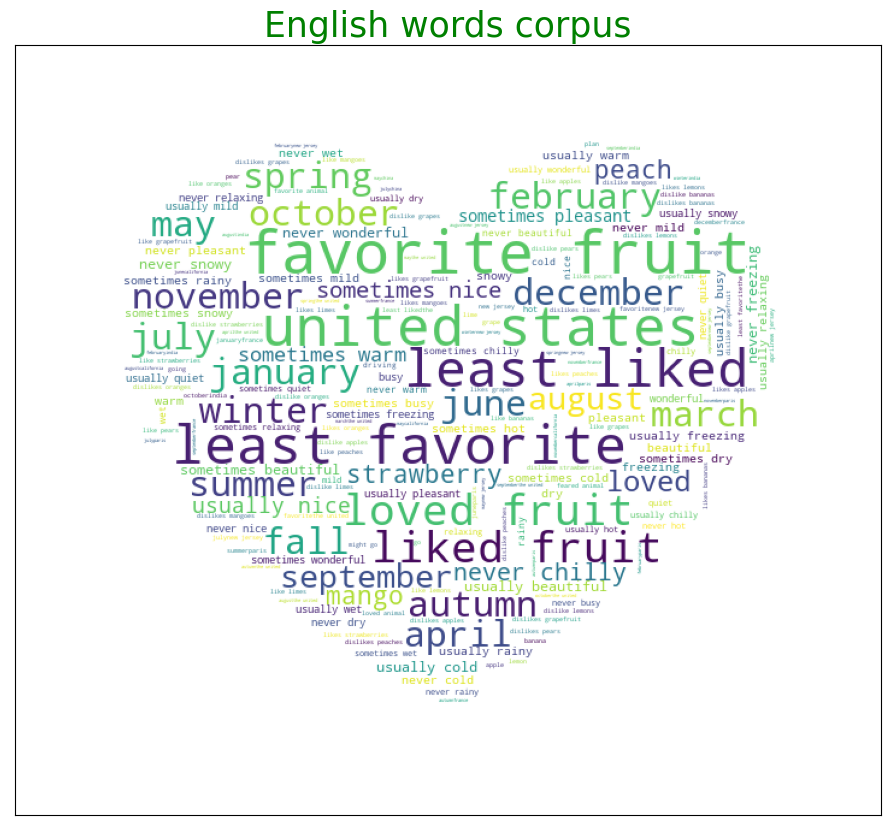

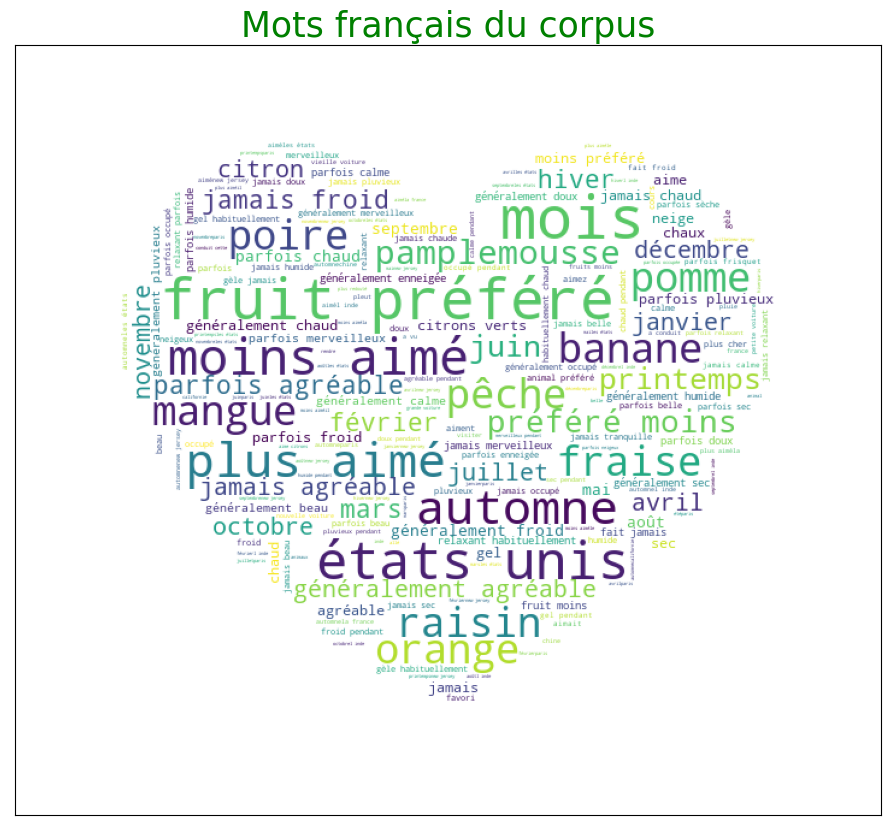

In [11]:
from PIL import Image
from wordcloud import WordCloud

def plot_word_cloud(text, title, masque, background_color = "white"):
    mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=200, 
                   stopwords=stop_words, mask = mask_coloring, 
                   max_font_size=50, random_state=42)
    # Générer et afficher le nuage de mots
    fig=plt.figure(figsize= (20,10))
    plt.title(title, fontsize=25, color="green")
    wc.generate(text)
    
    # getting current axes
    a = plt.gca()
 
    # set visibility of x-axis as False
    xax = a.axes.get_xaxis()
    xax = xax.set_visible(False)
 
    # set visibility of y-axis as False
    yax = a.axes.get_yaxis()
    yax = yax.set_visible(False)
    
    plt.imshow(wc)
    plt.show()

text = ""
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('english'))

for e in txt_en : text += e
plot_word_cloud(text, "English words corpus", "./images/coeur.png")

text = ""
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('french'))

for e in txt_fr : text += e
plot_word_cloud(text,"Mots français du corpus", "./images/coeur.png")

> **Calcul du nombre d'occurences des mots dans chaque langue**

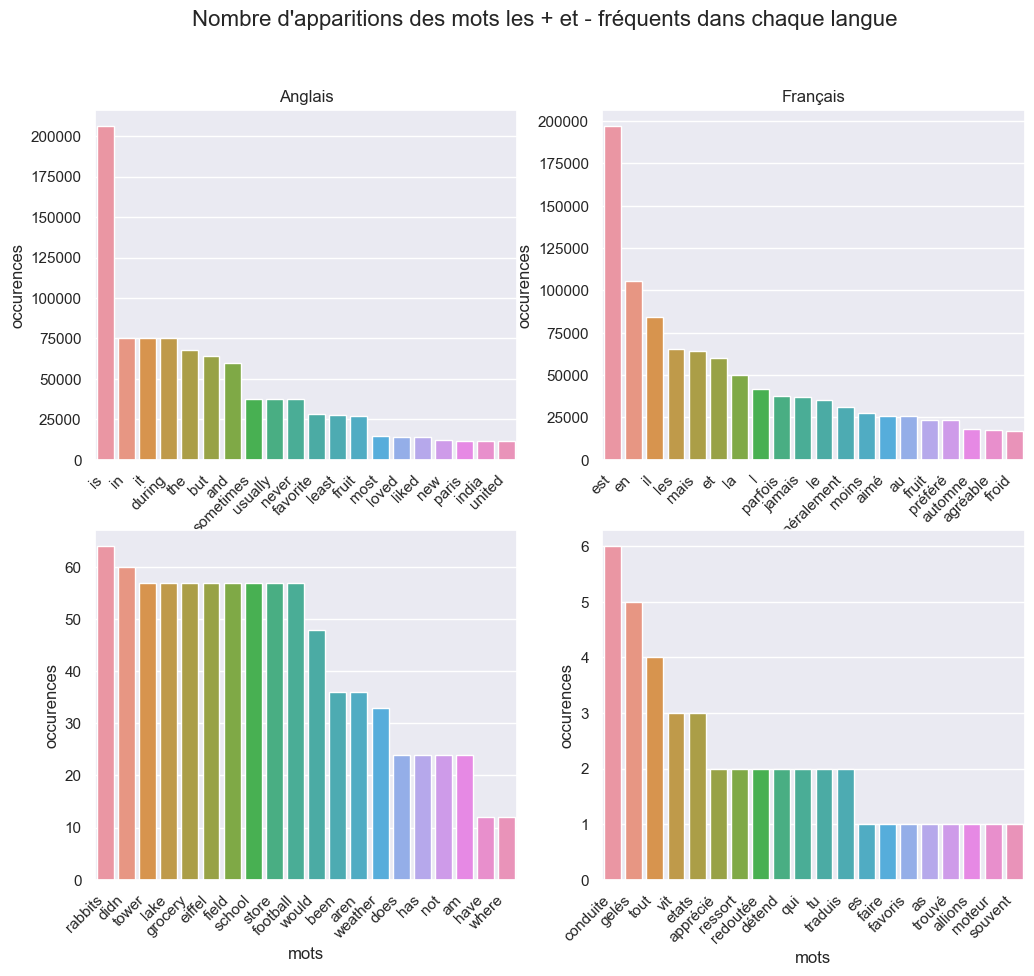

In [12]:
global nb_occurences_en, nb_occurences_fr

nb_occurences_en = pd.DataFrame(df_count_word_en.sum().sort_values(axis=0,ascending=False))
nb_occurences_en.columns = ['occurences']
nb_occurences_en.index.name = 'mot'
#print("Nombre d'occurences des mots en anglais:")
#display(nb_occurences_en)
nb_occurences_en['mots'] = nb_occurences_en.index


nb_occurences_fr = pd.DataFrame(df_count_word_fr.sum().sort_values(axis=0,ascending=False))
nb_occurences_fr.columns = ['occurences']
nb_occurences_fr.index.name = 'mot'
#print("\nNombre d'occurences des mots en français:")
#display(nb_occurences_fr)
nb_occurences_fr['mots'] = nb_occurences_fr.index

sns.set()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Nombre d'apparitions des mots les + et - fréquents dans chaque langue", fontsize=16)
axes[0,0].set_title('Anglais')
axes[0,1].set_title('Français')

chart1 = sns.barplot(ax=axes[0,0],x='mots',y='occurences',data=nb_occurences_en.iloc[:20]);
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')

chart2 = sns.barplot(ax=axes[0,1],x='mots',y='occurences',data=nb_occurences_fr.iloc[:20]);
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')

chart3 = sns.barplot(ax=axes[1,0],x='mots',y='occurences',data=nb_occurences_en.iloc[-20:]);
chart3.set_xticklabels(chart3.get_xticklabels(), rotation=45, horizontalalignment='right')

chart4 = sns.barplot(ax=axes[1,1],x='mots',y='occurences',data=nb_occurences_fr.iloc[-20:]);
chart4.set_xticklabels(chart4.get_xticklabels(), rotation=45, horizontalalignment='right');

> **Distribution des longueurs de phrases**
>
>On constate une grande similitude entre les 2 langues

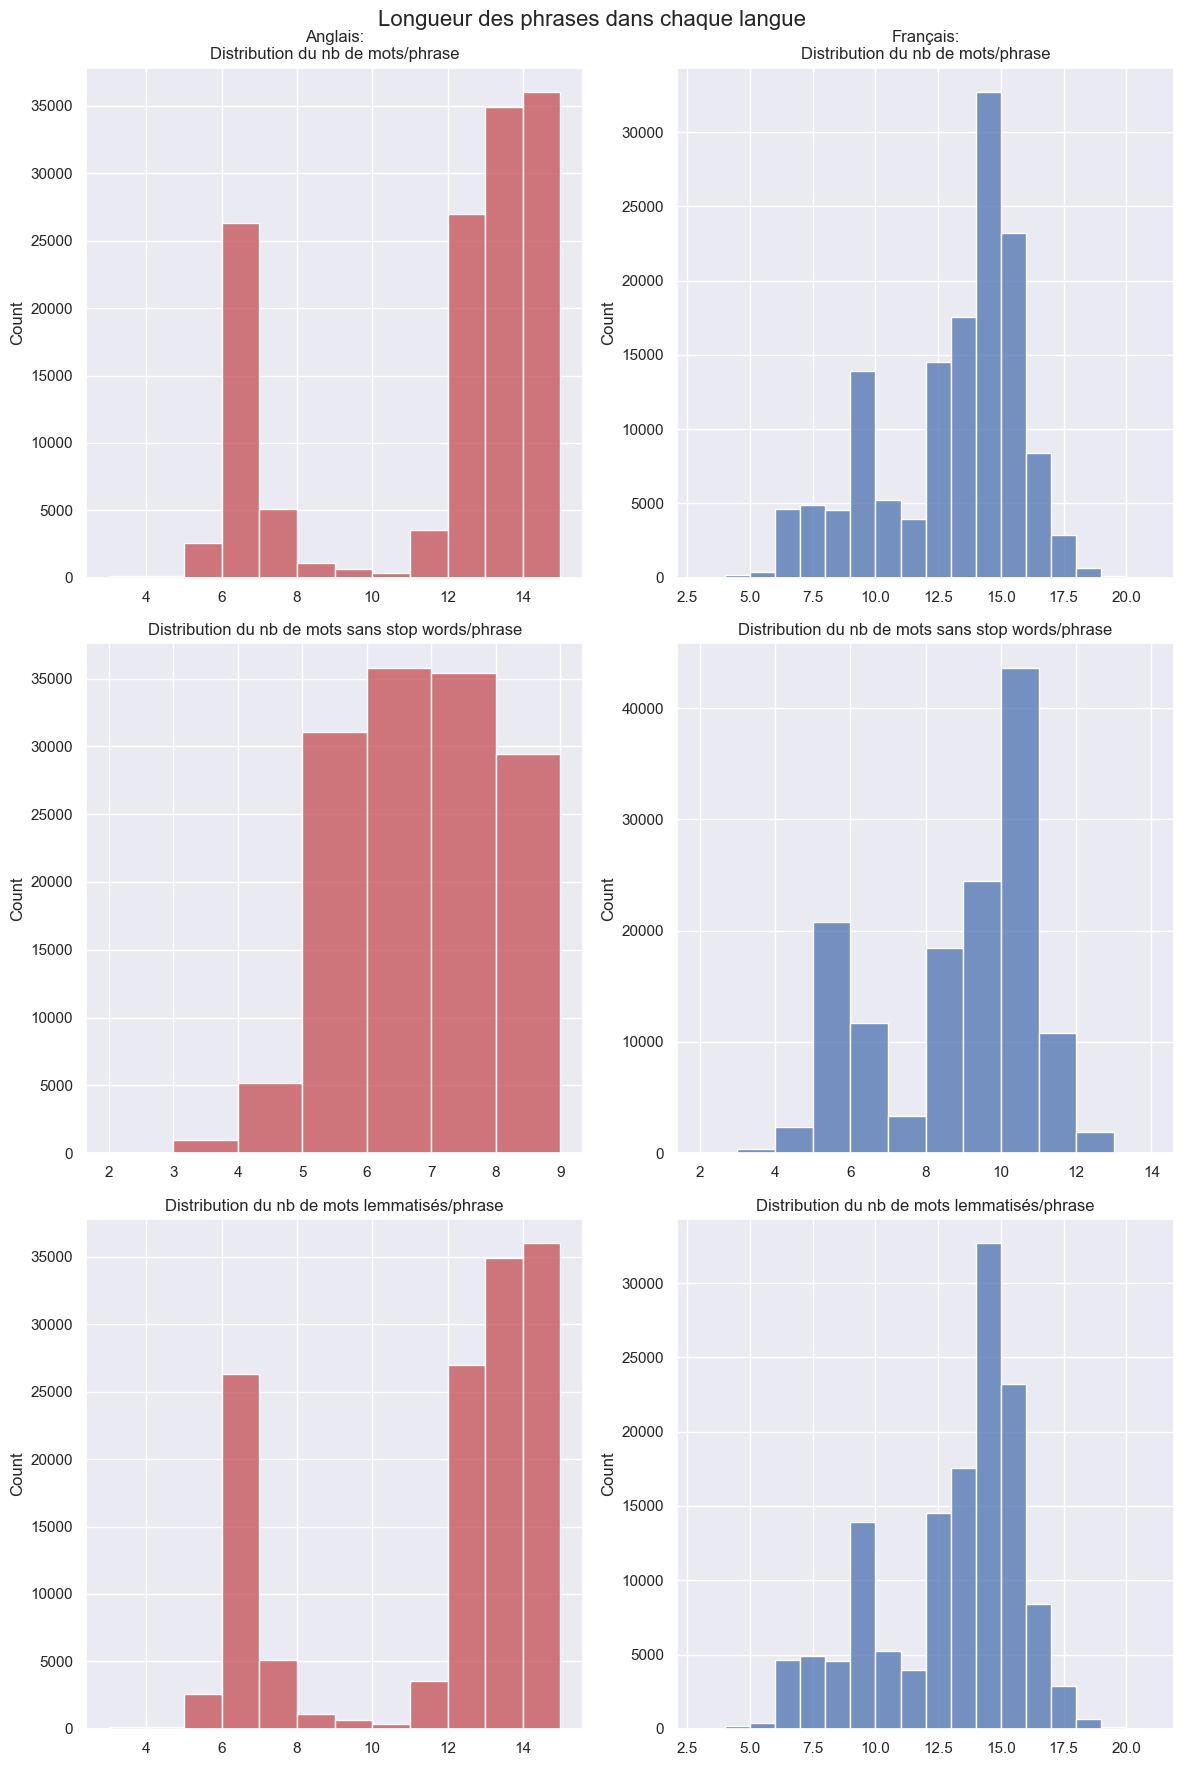

In [13]:
sns.set()
row_nb =1
if lemmatize_to_do: row_nb +=1
if stopwords_to_do: row_nb +=1
fig, axes = plt.subplots(row_nb, 2, figsize=(12, 6*row_nb))

fig.suptitle("Longueur des phrases dans chaque langue", fontsize=16)
fig.tight_layout()
axes = axes.ravel()

sns.histplot(data=sent_len_en, binwidth=1, color='r', ax=axes[0]).set(title='Anglais:\nDistribution du nb de mots/phrase');
sns.histplot(data=sent_len_fr, binwidth=1, color='b', ax=axes[1]).set(title='Français:\nDistribution du nb de mots/phrase');

if lemmatize_to_do:
    sns.histplot(data=sent_lem_len_en, binwidth=1, color='r', ax=axes[4]).set(title='Distribution du nb de mots lemmatisés/phrase');
    sns.histplot(data=sent_lem_len_fr, binwidth=1, color='b', ax=axes[5]).set(title='Distribution du nb de mots lemmatisés/phrase');

if stopwords_to_do:
    sns.histplot(data=sent_wo_sw_len_en, binwidth=1, color='r', ax=axes[2]).set(title='Distribution du nb de mots sans stop words/phrase');
    sns.histplot(data=sent_wo_sw_len_fr, binwidth=1, color='b', ax=axes[3]).set(title='Distribution du nb de mots sans stop words/phrase');

fig.tight_layout()
plt.show()

> **Représentation des co-occurences en réseau**

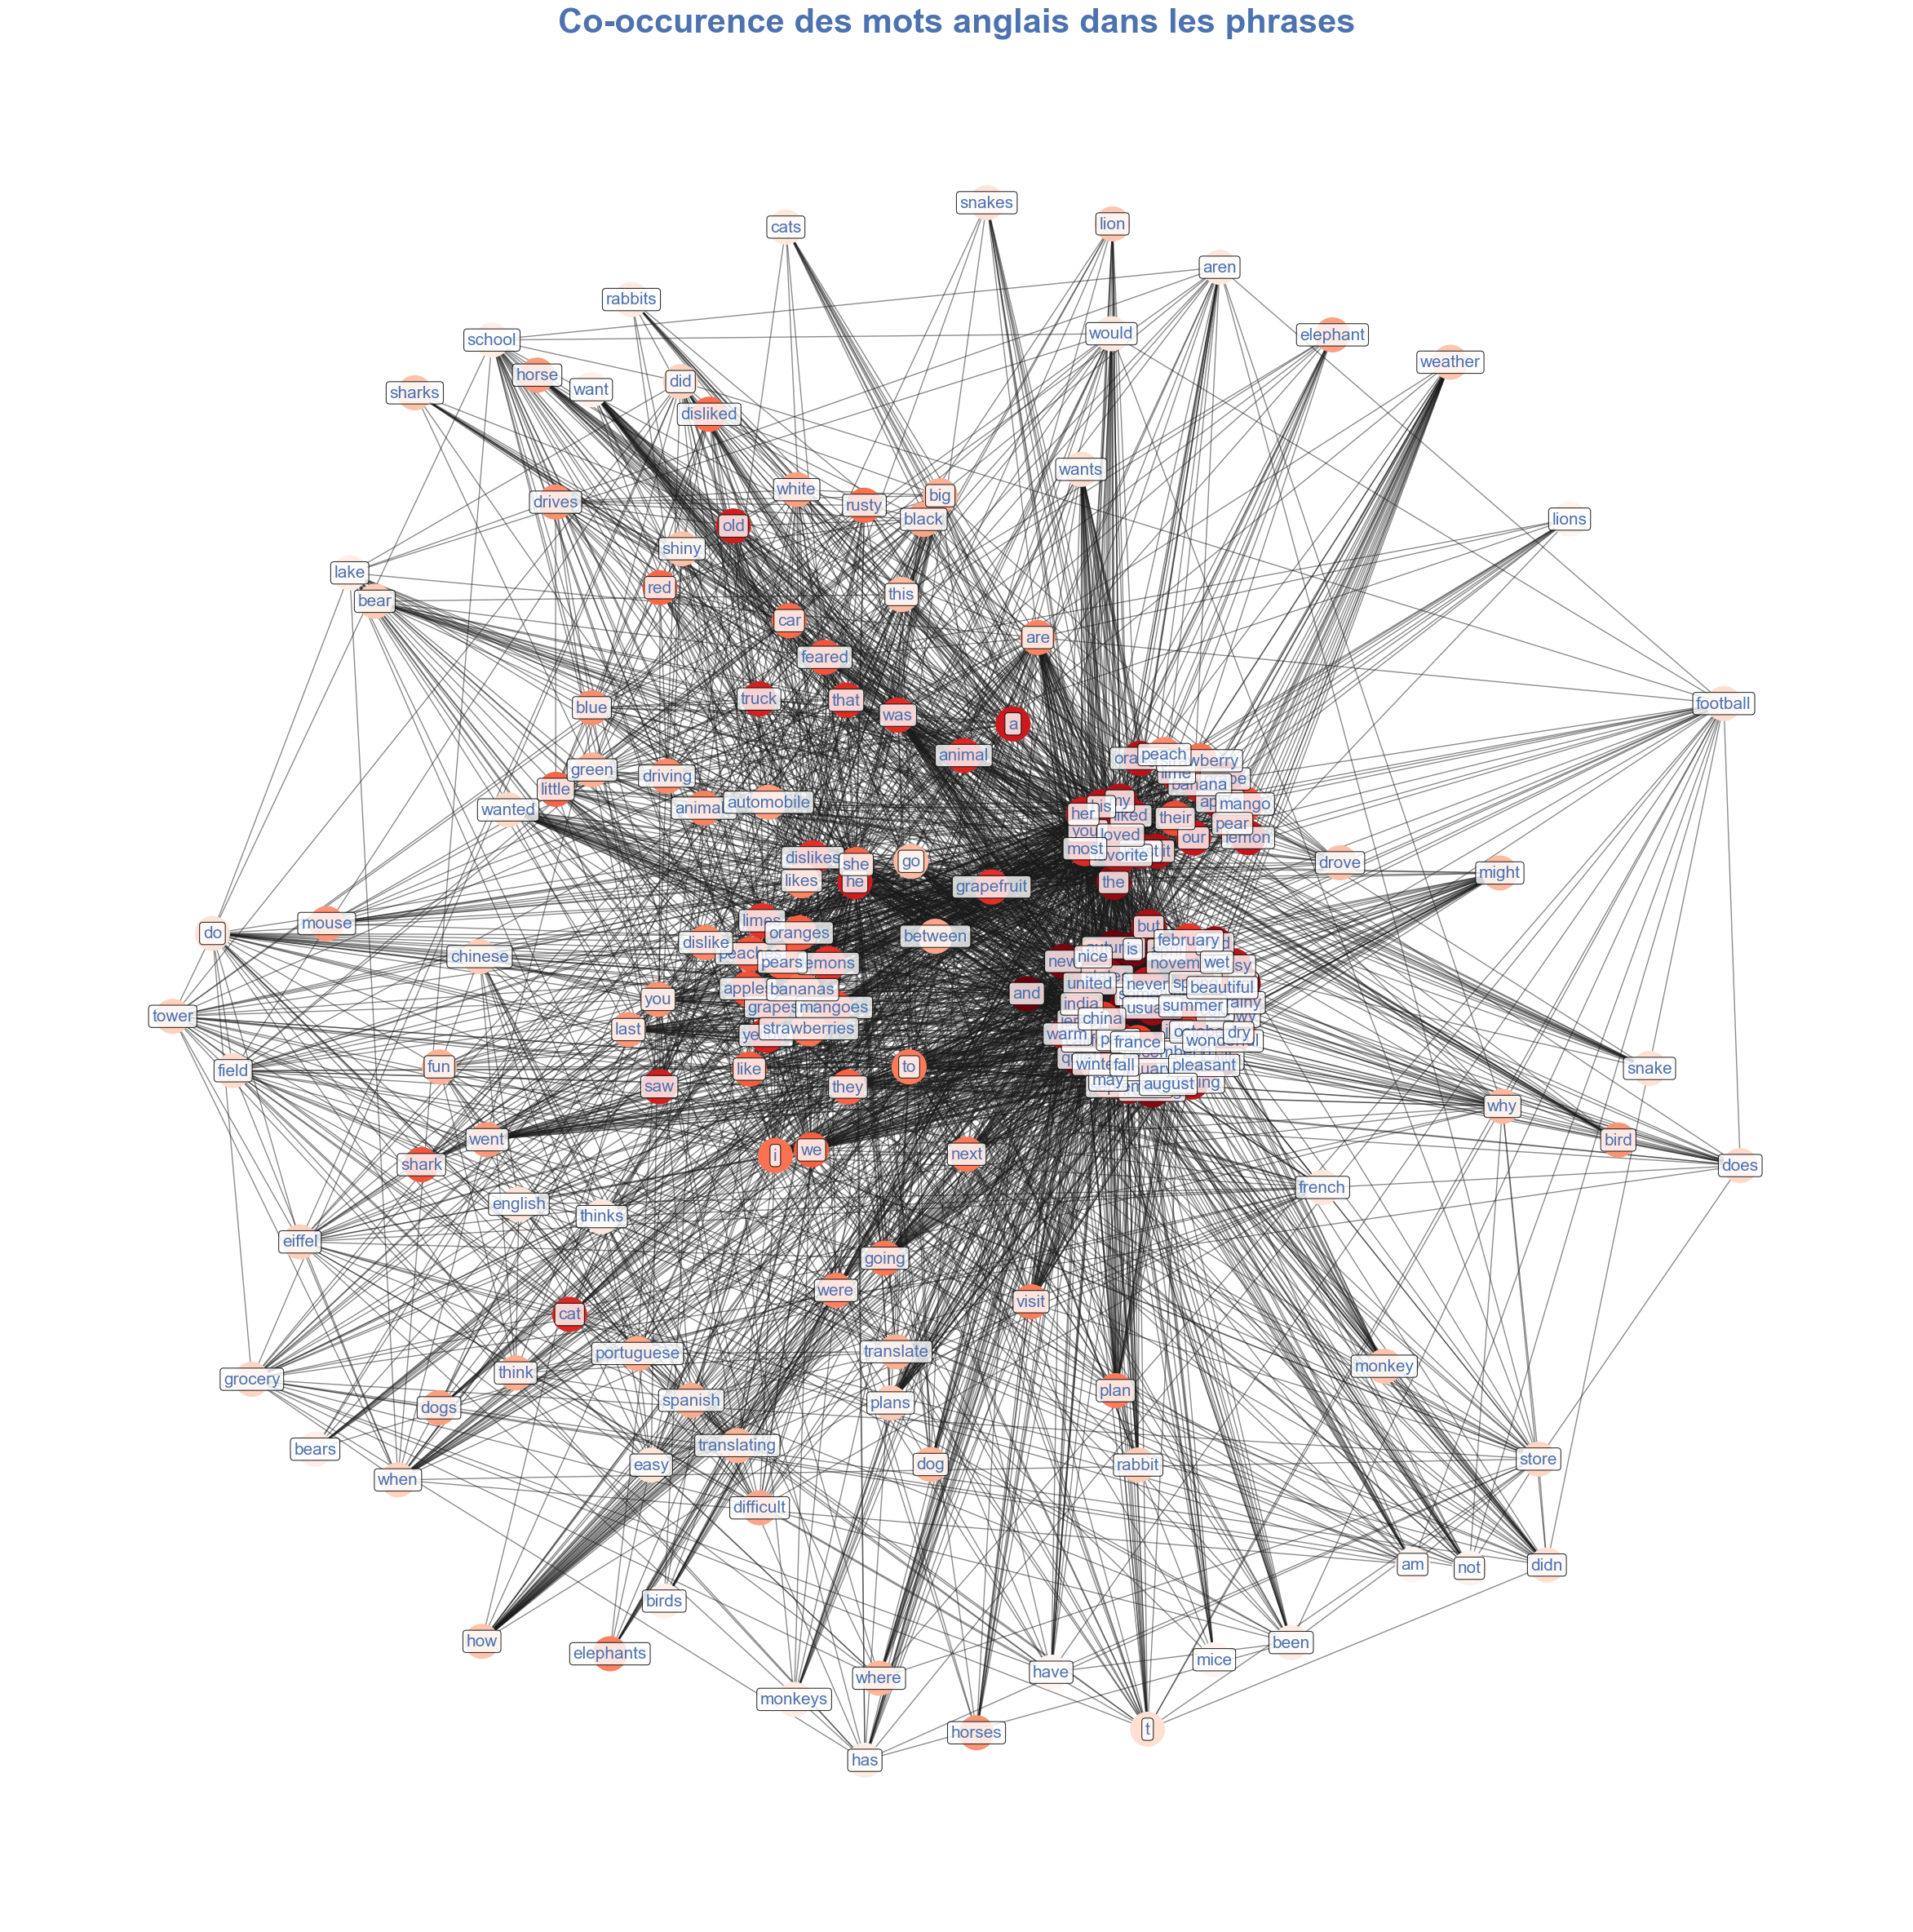

In [14]:
dic = corpora.Dictionary(txt_split_en) # dictionnaire de tous les mots restant dans le token
# Equivalent (ou presque) de la DTM : DFM, Document Feature Matrix
dfm = [dic.doc2bow(tok) for tok in txt_split_en]

mes_labels = [k for k, v in dic.token2id.items()]

from gensim.matutils import corpus2csc
term_matrice = corpus2csc(dfm)

import numpy as np
term_matrice = np.dot(term_matrice, term_matrice.T)

for i in range(len(mes_labels)):
    term_matrice[i,i]= 0
term_matrice.eliminate_zeros()

import networkx as nx
G = nx.from_scipy_sparse_matrix(term_matrice)
G.add_nodes = dic
pos=nx.spring_layout(G, k=5)  # position des nodes


plt.figure(figsize=(30, 30));
plt.title("Co-occurence des mots anglais dans les phrases", fontsize=30, color='b',fontweight="bold")

nx.draw_networkx_labels(G,pos,dic,font_size=15, font_color='b', bbox={"boxstyle": "round,pad=0.2", "fc":"white", "ec":"black", "lw":"0.8", "alpha" : 0.8} )
nx.draw_networkx_nodes(G,pos, dic,
                       node_color=range(len(corpus_en)),
                       node_size=900,
                       cmap=plt.cm.Reds_r,
                       alpha=1);
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)


plt.axis("off");

> **Distribution de certains mots dans une phrase**

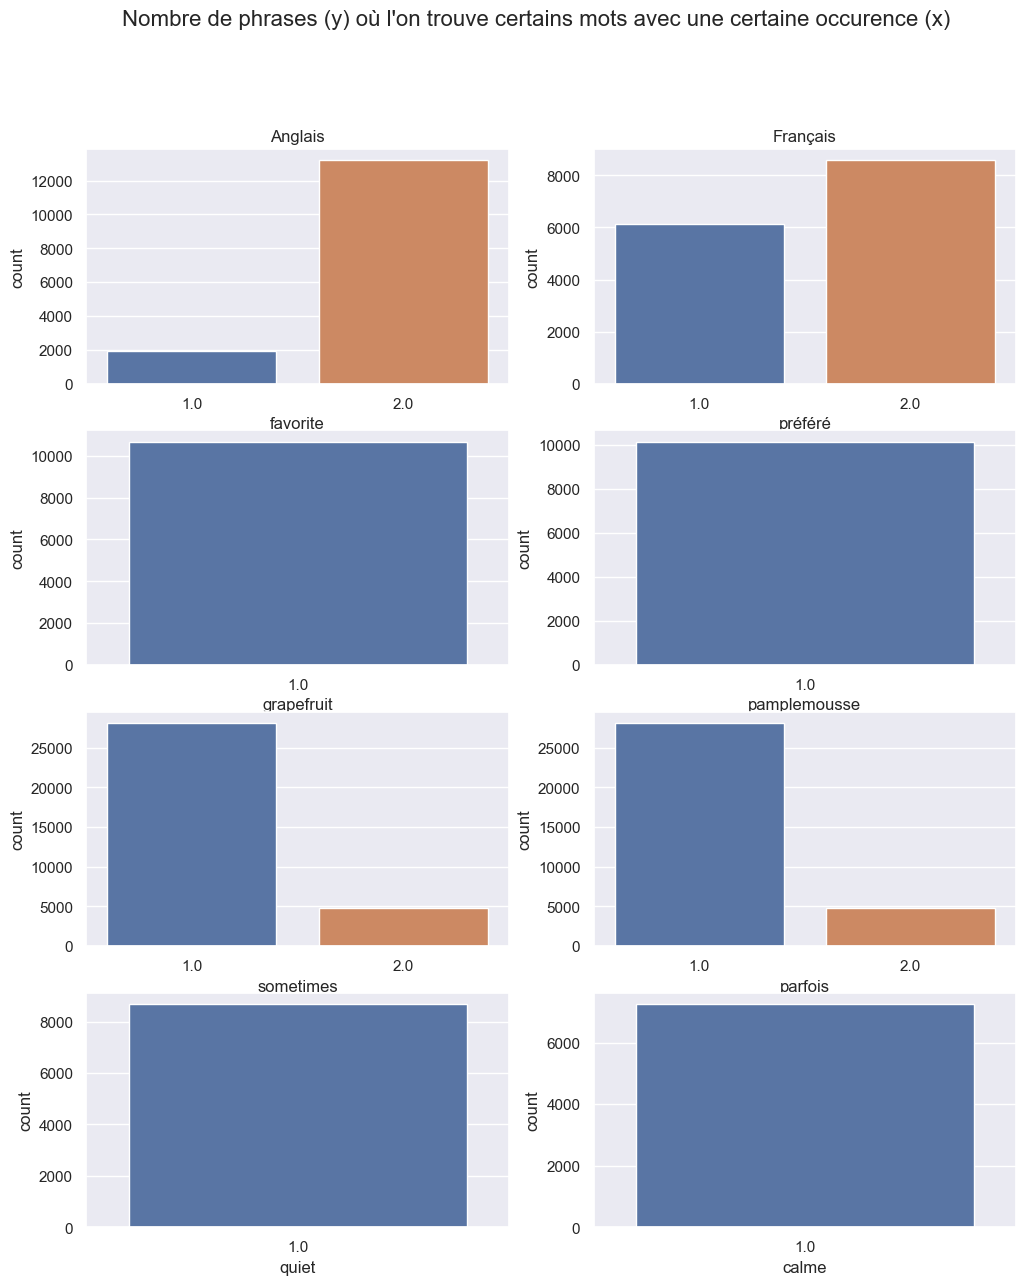

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
fig.suptitle("Nombre de phrases (y) où l'on trouve certains mots avec une certaine occurence (x)", fontsize=16)

axes[0,0].set_title('Anglais')
axes[0,1].set_title('Français')
sns.countplot(ax=axes[0,0],x=df_count_word_en['favorite'].loc[df_count_word_en['favorite']!=0.0]);
sns.countplot(ax=axes[1,0],x=df_count_word_en['grapefruit'].loc[df_count_word_en['grapefruit']!=0.0]);
sns.countplot(ax=axes[2,0],x=df_count_word_en['sometimes'].loc[df_count_word_en['sometimes']!=0.0]);
sns.countplot(ax=axes[3,0],x=df_count_word_en['quiet'].loc[df_count_word_en['quiet']!=0.0]);
sns.countplot(ax=axes[0,1],x=df_count_word_fr['préféré'].loc[df_count_word_fr['préféré']!=0.0]);
sns.countplot(ax=axes[1,1],x=df_count_word_fr['pamplemousse'].loc[df_count_word_fr['pamplemousse']!=0.0]);
sns.countplot(ax=axes[2,1],x=df_count_word_fr['parfois'].loc[df_count_word_fr['parfois']!=0.0]);
sns.countplot(ax=axes[3,1],x=df_count_word_fr['calme'].loc[df_count_word_fr['calme']!=0.0]);

=============================================

> **Création des dictionnaires de reference Anglais -> Français et Français -> Anglais**<br>

In [16]:
nb_mots_en = len(corpus_en)
nb_mots_fr = len(corpus_fr)

# On modifie df_count_word en indiquant la présence d'un mot par 1 (au lieu du nombre d'occurences)
df_count_word_en = df_count_word_en[df_count_word_en==0].fillna(1)
df_count_word_fr = df_count_word_fr[df_count_word_fr==0].fillna(1)

# On triche un peu parce que new et jersey sont toujours dans la même phrase et donc dans la même classe
df_count_word_en['new']=df_count_word_en['new']*2
df_count_word_fr['new']=df_count_word_fr['new']*2


> Pour evaluer l'efficacité, chargement des dictionnaires de reference (corrigés manuellement)

In [17]:
dict_FR_EN_ref = pd.read_csv('data/dict_fr_en2.csv',header=0,index_col=0, encoding ="utf-8", sep=';',keep_default_na=False).T
dict_EN_FR_ref = pd.read_csv('data/dict_en_fr2.csv',header=0,index_col=0, encoding ="utf-8", sep=';',keep_default_na=False).T
# display(dict_FR_EN_ref)
# display(dict_EN_FR_ref)

> Définition d'une fonction de **précision** du dictionnaire

In [18]:
def accuracy(dict_ref,dict):
    correct_words = 0
    
    for t in dict.columns:
        if t in dict_ref.columns:
            if str(dict[t]) == str(dict_ref[t]): 
                correct_words +=1
        else: print("dict ref: manque:",t)
    print(correct_words," mots corrects / ",min(dict.shape[1],dict_ref.shape[1]))
    return correct_words/min(dict.shape[1],dict_ref.shape[1])

# Préparation d'un tableau de bord 'Qualité de traduction'
translation_quality = pd.DataFrame(columns=['Précision du dictionnaire','Score Bleu Corpus'],dtype='float',
                                            index=['Reference EN->FR',
                                                   'K-Means EN->FR',
                                                   'KNN EN->FR',
                                                   'RF EN->FR',
                                                   'FastText EN->FR',
                                                   'Reference FR->EN',
                                                   'K-Means FR->EN',
                                                   'KNN FR->EN',
                                                   'RF FR->EN',
                                                   'FastText FR->EN'])

translation_quality['Précision du dictionnaire'].loc['Reference EN->FR'] = 100
translation_quality['Précision du dictionnaire'].loc['Reference FR->EN'] = 100

>> **CountVectorization** (Bag of words) : Création des dictionnaires à l'aide de la méthode non supervisée **KMeans**

In [19]:
# Création des dictionnaire Anglais -> Français

# Algorithme de K-means
init_centroids = df_count_word_fr.T
kmeans = KMeans(n_clusters = nb_mots_fr, n_init=1, max_iter=1, init=init_centroids, verbose=0)
# kmeans = KMedoids(n_clusters = nb_mots_fr, max_iter=10)

kmeans.fit(df_count_word_fr.T)

# Centroids and labels
centroids= kmeans.cluster_centers_
labels = kmeans.labels_

# Création et affichage du dictionnaire
dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[kmeans.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
dict_EN_FR.index.name='Anglais'
dict_EN_FR = dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
translation_quality['Précision du dictionnaire'].loc['K-Means EN->FR'] =round(accuracy(dict_EN_FR_ref,dict_EN_FR)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['K-Means EN->FR']}%")
display(dict_EN_FR)


Dictionnaire Anglais -> Français:
169  mots corrects /  199
Précision du dictionnaire = 84.92%


Anglais     a    am and  animal  animals  apple  apples  april   are     aren  \
Francais  une  vais  et  animal  animaux  pomme  pommes  avril  sont  allions   

Anglais   ...   when where    white       why winter    wonderful     would  \
Francais  ...  quand    où  blanche  pourquoi  hiver  merveilleux  voudrait   

Anglais  yellow   you   your  
Francais  jaune  vous  votre  

[1 rows x 199 columns]

In [20]:
# Création des dictionnaire Français -> Anglais

# Algorithme de K-means
init_centroids = df_count_word_en.T
kmeans = KMeans(n_clusters = nb_mots_en, n_init=1, max_iter=1, init=init_centroids, verbose=0)
#kmeans = KMedoids(n_clusters = nb_mots_en, max_iter=10)

kmeans.fit(df_count_word_en.T)

# Centroids and labels
centroids= kmeans.cluster_centers_
labels = kmeans.labels_

# Création et affichage du dictionnaire
dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[kmeans.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
dict_FR_EN.index.name='Francais'
dict_FR_EN = dict_FR_EN.T

print("Dictionnaire Français -> Anglais:")
translation_quality['Précision du dictionnaire'].loc['K-Means FR->EN'] =round(accuracy(dict_FR_EN_ref,dict_FR_EN)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['K-Means FR->EN']}%")
display(dict_FR_EN)

Dictionnaire Français -> Anglais:
153  mots corrects /  330
Précision du dictionnaire = 46.36%


Francais      a  agréable    aimait   aime aiment aimeraient aimez aimons  \
Anglais   drove  pleasant  disliked  likes   they       have   you   have   

Francais   aimé aimée  ...     à   école  éléphant  éléphants épicerie  \
Anglais   loved  have  ...  fall  school  elephant  elephants  grocery   

Francais étaient était   états     été  êtes  
Anglais     were   was  states  summer  have  

[1 rows x 330 columns]

>> **CountVectorization** (Bag of words) : Création des dictionnaires à l'aide de la méthode supervisée **KNN**

In [21]:
# Création des dictionnaire Anglais -> Français

#Définition de la metrique (pour les 2 dictionnaires
knn_metric = 'minkowski'   # minkowski, cosine, chebyshev, manhattan, euclidean

# Algorithme de KNN
X_train = df_count_word_fr.T
y_train = range(nb_mots_fr)

# Création du classifieur et construction du modèle sur les données d'entraînement
knn = KNeighborsClassifier(n_neighbors=1, metric=knn_metric)
knn.fit(X_train, y_train)

# Création et affichage du dictionnaire
knn_dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[knn.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
knn_dict_EN_FR.index.name='Anglais'
knn_dict_EN_FR = knn_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
translation_quality['Précision du dictionnaire'].loc['KNN EN->FR'] =round(accuracy(dict_EN_FR_ref,knn_dict_EN_FR)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['KNN EN->FR']}%")
display(knn_dict_EN_FR)

Dictionnaire Anglais -> Français:
171  mots corrects /  199
Précision du dictionnaire = 85.93%


Anglais     a    am and  animal  animals  apple  apples  april   are     aren  \
Francais  une  vais  et  animal  animaux  pomme  pommes  avril  sont  allions   

Anglais   ...   when where    white       why winter    wonderful     would  \
Francais  ...  quand    où  blanche  pourquoi  hiver  merveilleux  voudrait   

Anglais  yellow   you   your  
Francais  jaune  vous  votre  

[1 rows x 199 columns]

In [22]:
# Création des dictionnaire Français -> Anglais

#Définition de la metrique (pour les 2 dictionnaires
knn_metric = 'cosine'   # minkowski, cosine, chebyshev, manhattan, euclidean

# Algorithme de KNN
X_train = df_count_word_en.T
y_train = range(nb_mots_en)

# Création du classifieur et construction du modèle sur les données d'entraînement
knn = KNeighborsClassifier(n_neighbors=1, metric=knn_metric)
knn.fit(X_train, y_train)

# Création et affichage du dictionnaire
knn_dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[knn.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
knn_dict_FR_EN.index.name='Francais'
knn_dict_FR_EN = knn_dict_FR_EN.T

print("Dictionnaire Français -> Anglais:")
translation_quality['Précision du dictionnaire'].loc['KNN FR->EN'] =round(accuracy(dict_FR_EN_ref,knn_dict_FR_EN)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['KNN FR->EN']}%")
display(knn_dict_FR_EN)

Dictionnaire Français -> Anglais:
241  mots corrects /  330
Précision du dictionnaire = 73.03%


Francais      a  agréable    aimait   aime aiment aimeraient aimez aimons  \
Anglais   drove  pleasant  disliked  likes   they      would   you     we   

Francais   aimé  aimée  ...     à   école  éléphant  éléphants épicerie  \
Anglais   loved  loved  ...  fall  school  elephant  elephants  grocery   

Francais étaient était   états     été êtes  
Anglais     were   was  states  summer  did  

[1 rows x 330 columns]

>> **CountVectorization** (Bag of words) : Création des dictionnaires à l'aide de la méthode supervisée **Random Forest**

In [23]:
# Création des dictionnaire Anglais -> Français

# Algorithme de Random Forest
X_train = df_count_word_fr.T
y_train = range(nb_mots_fr)

# Création du classifieur et construction du modèle sur les données d'entraînement
rf = RandomForestClassifier(n_jobs=-1, random_state=321)
rf.fit(X_train, y_train)

# Création et affichage du dictionnaire
rf_dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[rf.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
rf_dict_EN_FR.index.name='Anglais'
rf_dict_EN_FR = rf_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
translation_quality['Précision du dictionnaire'].loc['RF EN->FR'] = round(accuracy(dict_EN_FR_ref,rf_dict_EN_FR)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['RF EN->FR']}%")
display(rf_dict_EN_FR)

Dictionnaire Anglais -> Français:
163  mots corrects /  199
Précision du dictionnaire = 81.91%


Anglais     a    am and  animal  animals  apple  apples  april   are   aren  \
Francais  une  vais  et  animal  animaux  pomme  pommes  avril  sont  allez   

Anglais   ...   when where  white       why winter    wonderful     would  \
Francais  ...  quand    où  blanc  pourquoi  hiver  merveilleux  voudrait   

Anglais  yellow   you   your  
Francais  jaune  vous  votre  

[1 rows x 199 columns]

In [24]:
# Création des dictionnaire Français -> Anglais

# Algorithme de Random Forest
X_train = df_count_word_en.T
y_train = range(nb_mots_en)

# Création du classifieur et construction du modèle sur les données d'entraînement
rf = RandomForestClassifier(n_jobs=-1, random_state=321)
rf.fit(X_train, y_train)

# Création et affichage du dictionnaire
rf_dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[rf.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
rf_dict_FR_EN.index.name='Francais'
rf_dict_FR_EN = rf_dict_FR_EN.T

print("Dictionnaire Anglais -> Français:")
translation_quality['Précision du dictionnaire'].loc['RF FR->EN'] = round(accuracy(dict_FR_EN_ref,rf_dict_FR_EN)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['RF FR->EN']}%")
display(rf_dict_FR_EN)

Dictionnaire Anglais -> Français:
174  mots corrects /  330
Précision du dictionnaire = 52.73%


Francais    a agréable    aimait   aime aiment aimeraient aimez aimons   aimé  \
Anglais   saw     nice  disliked  likes   they      where   you     we  loved   

Francais  aimée  ...     à   école  éléphant  éléphants épicerie étaient  \
Anglais   where  ...  fall  school  elephant  elephants    store    were   

Francais était   états     été   êtes  
Anglais    was  states  summer  where  

[1 rows x 330 columns]

>> **Création des dictionnaires à l'aide du Word Embedding**

>>>
>>> MUSE est une bibliothèque Python pour l'intégration de mots multilingues, dont l'objectif est de fournir à la communauté, notamment
>>> des "Word Embedding" multilingues (embeddings fastText alignés dans un espace commun)
>>>
>>> <img src="https://github.com/facebookresearch/MUSE/blob/main/outline_all.png?raw=true" style = "width:800px">
>>>
>>> Facebook fournit des dictionnaires de référence. Ces embeddings sont des embeddings fastText Wikipedia pour 30 langues qui ont été alignés dans un espace espace vectoriel unique.
>>>
>>> Dans notre cas, nous allons utiliser 2 mini-dictionnaires (Français et Anglais) alignés
>>>
>>> FastText est une bibliothèque pour l'apprentissage de word embeddings et la classification de textes. L'équipe de recherche de Facebook a créé fastText en novembre 2015. Fast-Text est une extension de la bibliothèque word2vec. Elle s'appuie sur Word2Vec en apprenant des représentations vectorielles pour chaque mot et les n-grammes trouvés dans chaque mot. FastText suppose qu'un mot est formé de n-grammes de caractères.


In [25]:
from gensim.models import FastText
from gensim.models import KeyedVectors

In [26]:
# lecture des dictionnaires complet (+ de 2 M de mots)
# en_model= KeyedVectors.load_word2vec_format('./data/wiki.en.align.vec')
# fr_model= KeyedVectors.load_word2vec_format('./data/wiki.fr.align.vec')

In [27]:
# identification des mots à conserver dans les dictionnaires allégés
# word_en_to_keep = load_data('./data/mini.list.en')
# word_fr_to_keep = load_data('./data/mini.list.fr')
# word_en_to_keep.pop(0)
# word_fr_to_keep.pop(0)

# def del_non_latin_words(liste):
#     r = re.compile(r"[a-zA-Z0-9áàâäãåçéèêëíìîïñóòôöõúùûüýÿæœÁÀÂÄÃÅÇÉÈÊËÍÌÎÏÑÓÒÔÖÕÚÙÛÜÝŸÆŒ]")
#     for w in liste:
#         if not r.match(w):
#             liste.remove(w)
#     return liste

# word_en_to_keep = del_non_latin_words(word_en_to_keep)
# word_en_to_keep= pd.DataFrame(word_en_to_keep)[0].unique().tolist()
# print("Nombre de mots anglais conservés dans le mini-dictionnaire anglais :",len(word_en_to_keep2))
# word_fr_to_keep = del_non_latin_words(word_fr_to_keep)
# word_fr_to_keep= pd.DataFrame(word_fr_to_keep)[0].unique().tolist()
# print("Nombre de mots français conservés dans le mini-dictionnaire français :",len(word_fr_to_keep2))

In [28]:
# Sauvegarde de dictionnaires allégés...
# import csv
# v_size = len(en_model.get_vector("a"))
# Ecriture d'un dictionbaire anglais mini
# with open('./data/mini.wiki.en.align.vec', 'w', newline='\n', encoding='UTF8') as csvfile:
#     line = csv.writer(csvfile, delimiter=' ')
#     line.writerow([len(word_en_to_keep),v_size] )
#     for word in word_en_to_keep:
#         v= en_model.get_vector(word)
#         l = [y for x in [[word], v] for y in x]
#         line.writerow(l)

# Ecriture d'un dictionbaire français mini
# with open('./data/mini.wiki.fr.algn.vec', 'w', newline='\n', encoding='UTF8') as csvfile:
#     line = csv.writer(csvfile, delimiter=' ')
#     line.writerow([len(word_fr_to_keep),v_size] )
#     for word in word_fr_to_keep:
#         v= fr_model.get_vector(word)
#         l = [y for x in [[word], v] for y in x]
#         line.writerow(l)

In [29]:
# lecture des dictionnaires allégés

# Pretrained Word2Vec
en_model= KeyedVectors.load_word2vec_format('./data/mini.wiki.en.align.vec')
fr_model= KeyedVectors.load_word2vec_format('./data/mini.wiki.fr.align.vec')

nb_word_wiki_en = len(en_model)
nb_word_wiki_fr = len(fr_model)
print("Nombre de mots du dictionnaire anglais  allegé:",nb_word_wiki_en)
print("Nombre de mots du dictionnaire français allegé:",nb_word_wiki_fr)

Nombre de mots du dictionnaire anglais  allegé: 3095
Nombre de mots du dictionnaire français allegé: 1144


>> **Exemple** de calcul sur les **vecteurs de Word Embedding**, contenant de la sémantique

In [30]:
# traduction de : 'king' + 'man' - 'woman' = 'reine' 
vect1 = en_model.get_vector("king")
vect2 = en_model.get_vector("man")
vect3 = en_model.get_vector("woman")
print("Traduction en français de ('king' - 'man' + 'woman') = ",fr_model.most_similar(vect1-vect2+vect3)[0][0])


Traduction en français de ('king' - 'man' + 'woman') =  reine


In [31]:
fr_model.most_similar("hiver")

[('automne', 0.6660692095756531),
 ('printemps', 0.6183713674545288),
 ('neigeux', 0.5664983987808228),
 ('neige', 0.5257566571235657),
 ('enneigée', 0.5075902938842773),
 ('pluvieux', 0.503300130367279),
 ('enneigé', 0.4926919639110565),
 ('froid', 0.47274085879325867),
 ('gelé', 0.4528149366378784),
 ('gèle', 0.45185184478759766)]

In [32]:
# Génération des traductions de tous les mots du chaque corpus
trad_fr = [fr_model.most_similar(en_model.get_vector(t))[0][0] for t in corpus_en]
trad_en = [en_model.most_similar(positive=[fr_model.get_vector(t)])[0][0] for t in corpus_fr]


In [33]:
# Création des dictionnaire Anglais -> Français, et affichage
we_dict_EN_FR = pd.DataFrame(data=trad_fr,index=corpus_en,columns=['Francais'])
we_dict_EN_FR.index.name='Anglais'
we_dict_EN_FR = we_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
translation_quality['Précision du dictionnaire'].loc['FastText EN->FR'] = round(accuracy(dict_EN_FR_ref,we_dict_EN_FR)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['FastText EN->FR']}%")
display(we_dict_EN_FR)


Dictionnaire Anglais -> Français:
109  mots corrects /  199
Précision du dictionnaire = 54.77%


Anglais     a  am and   animal  animals  apple  apples    april   are  aren  \
Francais  une  je  et  animaux  animaux  pomme  pommes  février  sont  sont   

Anglais   ...     when where  white       why winter    wonderful     would  \
Francais  ...  lorsque    où  blanc  pourquoi  hiver  merveilleux  pourrait   

Anglais  yellow you   your  
Francais  jaune  me  votre  

[1 rows x 199 columns]

In [34]:
# Création des dictionnaire Français -> Anglais, et affichage
we_dict_FR_EN = pd.DataFrame(data=trad_en,index=corpus_fr,columns=['Anglais'])
we_dict_FR_EN.index.name='Francais'
we_dict_FR_EN = we_dict_FR_EN.T

print("Dictionnaire Français -> Anglais :")
translation_quality['Précision du dictionnaire'].loc['FastText FR->EN'] = round(accuracy(dict_FR_EN_ref,we_dict_FR_EN)*100, 2)
print(f"Précision du dictionnaire = {translation_quality['Précision du dictionnaire'].loc['FastText FR->EN']}%")
display(we_dict_FR_EN)

Dictionnaire Français -> Anglais :
173  mots corrects /  330
Précision du dictionnaire = 52.42%


Francais    a  agréable aimait  aime aiment aimeraient aimez aimons   aimé  \
Anglais   has  pleasant  loved  love  enjoy       want  dare   come  loved   

Francais  aimée  ...   à   école  éléphant  éléphants épicerie étaient était  \
Anglais   loved  ...  to  school  elephant  elephants  grocery    were   was   

Francais   états   été êtes  
Anglais   states  been  ask  

[1 rows x 330 columns]

>> **Affichage de la proximité des mots et de leur traduction**

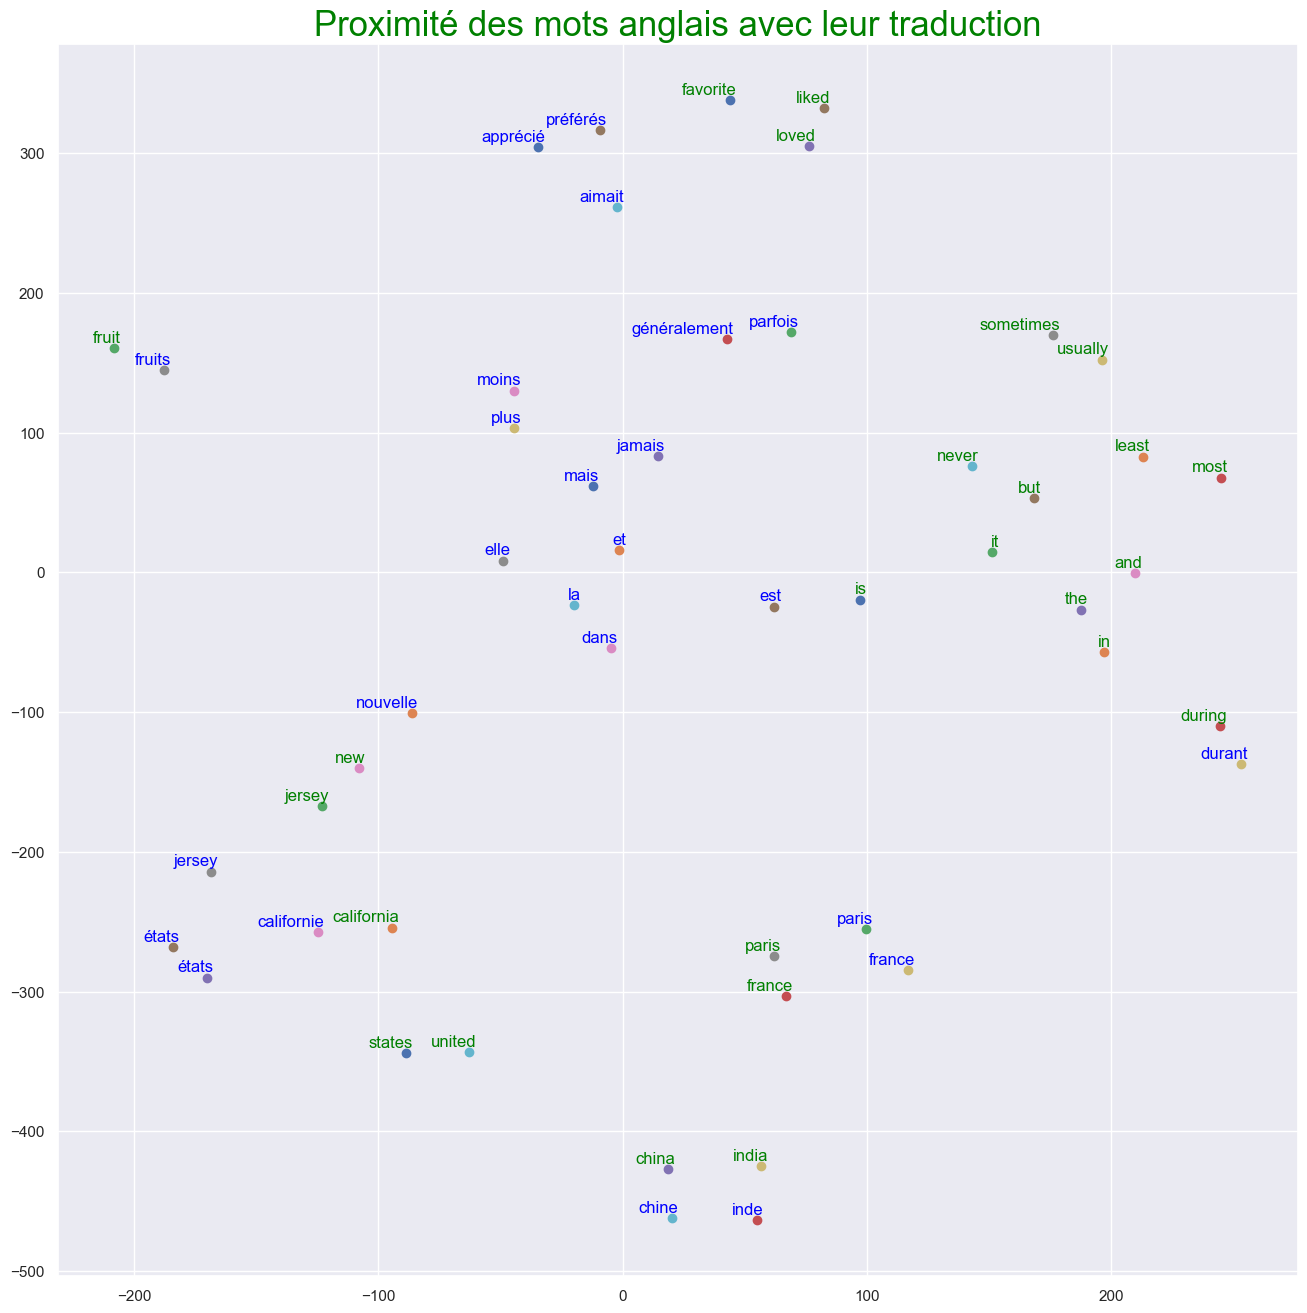

In [35]:
from sklearn.manifold import TSNE
global nb_occurences_en

"Creates and TSNE model and plots it"
labels = []
tokens = []

nb_words = 25
words_en = nb_occurences_en.iloc[:nb_words,0].index.tolist()
words_fr = (we_dict_EN_FR[words_en].T)['Francais'].tolist()

for word in words_en: #['is','sometimes','usually', 'favorite', 'loved', 'paris']: #corpus_en:
    tokens.append(en_model[word])
    labels.append(word)
for word in words_fr: # ['est', 'parfois', 'généralement', 'préféré', 'aimé', 'paris']: # corpus_fr:
    tokens.append(fr_model[word])
    labels.append(word)
tokens = pd.DataFrame(tokens)

tsne_model = TSNE(perplexity=6, n_components=2, init='pca', n_iter=5000, random_state=23)
new_values = tsne_model.fit_transform(tokens)

fig=plt.figure(figsize=(16, 16)) 
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
for i in range(len(x)):
    if i<nb_words  : color='green'
    else: color='blue'
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 color= color)
    plt.title("Proximité des mots anglais avec leur traduction", fontsize=25, color="green")
plt.show()

 



> **Illustration d'anomalies générées par les modèles CountVectorization:**<br>
> Exemple: "the" traduit par "fruit" au lieu de "le" ou "la"

In [36]:
word_en = 'the'
word_fr1 = 'le'
word_fr2 = 'la'
word_fr_pred = dict_EN_FR[word_en][0]
print("Nombre de fois que l'on trouve le mot '",word_en,"' dans le texte anglais :",df_count_word_en[word_en].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr_pred,"' dans le texte français :",df_count_word_fr[word_fr_pred].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr1,"' dans le texte français :",df_count_word_fr[word_fr1].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr2,"' dans le texte français :",df_count_word_fr[word_fr2].sum())

Nombre de fois que l'on trouve le mot ' the ' dans le texte anglais : 41221.0
Nombre de fois que l'on trouve le mot ' fruit ' dans le texte français : 23626.0
Nombre de fois que l'on trouve le mot ' le ' dans le texte français : 28877.0
Nombre de fois que l'on trouve le mot ' la ' dans le texte français : 39038.0


> **Exemples de traduction de phrase anglaise en utilisant les dictionnaire Anglais -> Français**

In [37]:
def clean_sentence_to_translate(sentence,lang):
    sentence = sentence.replace(' .','')
    return clean_undesirable_from_text(sentence.replace('.',''), lang).split(' ')

def display_translation(s,sentence, diction, txt_ref):
    for i in range(len(s)):
        display(diction[sentence[i]])
        print("Ref.  : ",txt_ref[s[i]],f"  -> Score Bleu = {sentence_bleu(' '.join(diction[sentence[i]].iloc[0].tolist()),[txt_ref[s[i]]]).score:.1f}%\n\n")
    return

s = [18, 178, 13, random.randrange(len(txt_en))]  # Numero des phrase à traduire dans le corpus

# Phrases à traduire
sentence = [ txt_split_en[s[0]], # "paris is never freezing during november but it is wonderful in october"
             txt_split_en[s[1]], # "the banana is their favorite fruit but the grapefruit is your favorite"
             txt_split_en[s[2]], # "that cat was my most loved anima"
             txt_split_en[s[3]]] # Phrase tirée au sort 

print("\nTraduction à l'aide du dictionnaire de reference:")
display_translation(s, sentence, dict_EN_FR_ref, txt_fr)
print("======================")
print("\nTraduction à l'aide du dictionnaire Kmeans calculés:")
display_translation(s, sentence, dict_EN_FR, txt_fr)
print("======================")
print("\nTraduction à l'aide du dictionnaire KNN calculés:")
display_translation(s, sentence, knn_dict_EN_FR, txt_fr)
print("======================")
print("\nTraduction à l'aide du dictionnaire RF calculés:")
display_translation(s, sentence, rf_dict_EN_FR, txt_fr)
print("======================")
print("\nTraduction à l'aide du dictionnaires Word Embedding FastText:")
display_translation(s, sentence, we_dict_EN_FR, txt_fr)



Traduction à l'aide du dictionnaire de reference:


Anglais   paris   is   never freezing during  november   but  it   is  \
Francais  paris  est  jamais      gel     en  novembre  mais  il  est   

Anglais     wonderful  in  october  
Francais  merveilleux  en  octobre

Ref.  :  paris est jamais le gel en novembre mais il est merveilleux en octobre   -> Score Bleu = 76.8%




Anglais  the  banana   is their favorite  fruit   but the    grapefruit   is  \
Francais  le  banane  est  leur  préféré  fruit  mais  le  pamplemousse  est   

Anglais    your favorite  
Francais  votre  préféré

Ref.  :  la banane est leur fruit préféré mais le pamplemousse est votre favori   -> Score Bleu = 44.8%




Anglais    that   cat    was   my  most loved  animal
Francais  cette  chat  était  mon  plus  cher  animal

Ref.  :  ce chat était mon animal le plus aimé   -> Score Bleu = 24.1%




Anglais     we    like  apples peaches and  oranges
Francais  nous  aiment  pommes  pêches  et  oranges

Ref.  :  nous aimons les pommes les pêches et les oranges   -> Score Bleu = 12.4%



Traduction à l'aide du dictionnaire Kmeans calculés:


Anglais   paris   is   never freezing during  november   but  it   is  \
Francais  paris  est  jamais      gel     en  novembre  mais  en  est   

Anglais     wonderful  in  october  
Francais  merveilleux  en  octobre

Ref.  :  paris est jamais le gel en novembre mais il est merveilleux en octobre   -> Score Bleu = 48.0%




Anglais     the  banana   is their favorite  fruit   but    the    grapefruit  \
Francais  fruit  banane  est  leur  préféré  fruit  mais  fruit  pamplemousse   

Anglais    is   your favorite  
Francais  est  votre  préféré

Ref.  :  la banane est leur fruit préféré mais le pamplemousse est votre favori   -> Score Bleu = 23.5%




Anglais    that   cat    was   my  most loved  animal
Francais  cette  chat  était  mon  plus  plus  animal

Ref.  :  ce chat était mon animal le plus aimé   -> Score Bleu = 24.1%




Anglais     we    like  apples peaches and  oranges
Francais  nous  aimons  pommes  pêches  et  oranges

Ref.  :  nous aimons les pommes les pêches et les oranges   -> Score Bleu = 15.4%



Traduction à l'aide du dictionnaire KNN calculés:


Anglais   paris   is   never freezing during  november   but  it   is  \
Francais  paris  est  jamais      gel     en  novembre  mais  en  est   

Anglais     wonderful  in  october  
Francais  merveilleux  en  octobre

Ref.  :  paris est jamais le gel en novembre mais il est merveilleux en octobre   -> Score Bleu = 48.0%




Anglais     the  banana   is their favorite  fruit   but    the    grapefruit  \
Francais  fruit  banane  est  leur  préféré  fruit  mais  fruit  pamplemousse   

Anglais    is   your favorite  
Francais  est  votre  préféré

Ref.  :  la banane est leur fruit préféré mais le pamplemousse est votre favori   -> Score Bleu = 23.5%




Anglais    that   cat    was   my  most loved  animal
Francais  cette  chat  était  mon  plus  plus  animal

Ref.  :  ce chat était mon animal le plus aimé   -> Score Bleu = 24.1%




Anglais     we    like  apples peaches and  oranges
Francais  nous  aimons  pommes  pêches  et  oranges

Ref.  :  nous aimons les pommes les pêches et les oranges   -> Score Bleu = 15.4%



Traduction à l'aide du dictionnaire RF calculés:


Anglais   paris   is   never freezing during  november   but  it   is  \
Francais  paris  est  jamais      gel     en  novembre  mais  en  est   

Anglais     wonderful  in  october  
Francais  merveilleux  en  octobre

Ref.  :  paris est jamais le gel en novembre mais il est merveilleux en octobre   -> Score Bleu = 48.0%




Anglais     the  banana   is their favorite  fruit   but    the    grapefruit  \
Francais  fruit  banane  est  leur  préféré  fruit  mais  fruit  pamplemousse   

Anglais    is   your favorite  
Francais  est  votre  préféré

Ref.  :  la banane est leur fruit préféré mais le pamplemousse est votre favori   -> Score Bleu = 23.5%




Anglais    that   cat    was   my  most loved  animal
Francais  cette  chat  était  mon  plus  plus  animal

Ref.  :  ce chat était mon animal le plus aimé   -> Score Bleu = 24.1%




Anglais     we    like  apples peaches and  oranges
Francais  nous  aiment  pommes  pêches  et  oranges

Ref.  :  nous aimons les pommes les pêches et les oranges   -> Score Bleu = 12.4%



Traduction à l'aide du dictionnaires Word Embedding FastText:


Anglais   paris   is   never freezing  during november   but    it   is  \
Francais  paris  est  jamais    froid  durant  février  mais  elle  est   

Anglais     wonderful    in  october  
Francais  merveilleux  dans  février

Ref.  :  paris est jamais le gel en novembre mais il est merveilleux en octobre   -> Score Bleu = 15.3%




Anglais  the   banana   is  their  favorite   fruit   but the    grapefruit  \
Francais  la  bananes  est  leurs  préférés  fruits  mais  la  pamplemousse   

Anglais    is   your  favorite  
Francais  est  votre  préférés

Ref.  :  la banane est leur fruit préféré mais le pamplemousse est votre favori   -> Score Bleu = 15.0%




Anglais  that   cat    was   my  most   loved   animal
Francais  que  chat  était  mon  plus  aimait  animaux

Ref.  :  ce chat était mon animal le plus aimé   -> Score Bleu = 22.8%




Anglais       we        like  apples peaches and  oranges
Francais  allons  ressembler  pommes  poires  et  oranges

Ref.  :  nous aimons les pommes les pêches et les oranges   -> Score Bleu = 6.5%




> **Exemples de traduction de phrase anglaise en utilisant les dictionnaire Français -> Anglais**

In [38]:
# Phrases à traduire
sentence = [ txt_split_fr[s[0]], # "paris est jamais le gel en novembre mais il est merveilleux en octobre",
             txt_split_fr[s[1]], # "la banane est leur fruit préféré mais le pamplemousse est votre favori"
             txt_split_fr[s[2]], # "ce chat était mon animal le plus aimé"
             txt_split_fr[s[3]]] # Phrase tirée au sort 

print("\nTraduction à l'aide du dictionnaire de reference:")
display_translation(s, sentence, dict_FR_EN_ref, txt_en)
print("======================")
print("\nTraduction à l'aide du dictionnaire Kmeans calculés:")
display_translation(s, sentence, dict_FR_EN, txt_en)
print("======================")
print("\nTraduction à l'aide du dictionnaire KNN calculés:")
display_translation(s, sentence, knn_dict_FR_EN, txt_en)
print("======================")
print("\nTraduction à l'aide du dictionnaire RF calculés:")
display_translation(s, sentence, rf_dict_FR_EN, txt_en)
print("======================")
print("\nTraduction à l'aide du dictionnaires Word Embedding FastText:")
display_translation(s, sentence, we_dict_FR_EN, txt_en)




Traduction à l'aide du dictionnaire de reference:


Francais  paris est jamais   le       gel  en  novembre mais  il est  \
Anglais   paris  is  never  the  freezing  in  november  but  it  is   

Francais merveilleux  en  octobre  
Anglais    wonderful  in  october

Ref.  :  paris is never freezing during november but it is wonderful in october   -> Score Bleu = 59.2%




Francais   la  banane est   leur  fruit   préféré mais   le pamplemousse est  \
Anglais   the  banana  is  their  fruit  favorite  but  the   grapefruit  is   

Francais votre    favori  
Anglais   your  favorite

Ref.  :  the banana is their favorite fruit but the grapefruit is your favorite   -> Score Bleu = 66.4%




Francais    ce chat était mon  animal   le  plus   aimé
Anglais   this  cat   was  my  animal  the  most  loved

Ref.  :  that cat was my most loved animal   -> Score Bleu = 27.1%




Francais nous aimons  les  pommes  les   pêches   et  les  oranges
Anglais    we   like  the  apples  the  peaches  and  the  oranges

Ref.  :  we like apples peaches and oranges   -> Score Bleu = 14.9%



Traduction à l'aide du dictionnaire Kmeans calculés:


Francais  paris est jamais          le       gel  en  novembre mais  il est  \
Anglais   paris  is  never  grapefruit  freezing  in  november  but  it  is   

Francais merveilleux  en  octobre  
Anglais    wonderful  in  october

Ref.  :  paris is never freezing during november but it is wonderful in october   -> Score Bleu = 59.2%




Francais     la  banane est   leur  fruit   préféré mais          le  \
Anglais   fruit  banana  is  their  fruit  favorite  but  grapefruit   

Francais pamplemousse est     votre favori  
Anglais    grapefruit  is  football   have

Ref.  :  the banana is their favorite fruit but the grapefruit is your favorite   -> Score Bleu = 17.8%




Francais    ce chat était mon  animal          le  plus   aimé
Anglais   this  cat   was  my  animal  grapefruit  most  loved

Ref.  :  that cat was my most loved animal   -> Score Bleu = 27.1%




Francais nous aimons     les  pommes     les   pêches   et     les  oranges
Anglais    we   have  states  apples  states  peaches  and  states  oranges

Ref.  :  we like apples peaches and oranges   -> Score Bleu = 12.0%



Traduction à l'aide du dictionnaire KNN calculés:


Francais  paris est jamais     le       gel  en  novembre mais  il est  \
Anglais   paris  is  never  fruit  freezing  in  november  but  it  is   

Francais merveilleux  en  octobre  
Anglais    wonderful  in  october

Ref.  :  paris is never freezing during november but it is wonderful in october   -> Score Bleu = 59.2%




Francais     la  banane est   leur  fruit   préféré mais     le pamplemousse  \
Anglais   fruit  banana  is  their  fruit  favorite  but  fruit   grapefruit   

Francais est votre    favori  
Anglais   is  your  favorite

Ref.  :  the banana is their favorite fruit but the grapefruit is your favorite   -> Score Bleu = 33.5%




Francais    ce chat était mon  animal     le  plus   aimé
Anglais   this  cat   was  my  animal  fruit  most  loved

Ref.  :  that cat was my most loved animal   -> Score Bleu = 27.1%




Francais nous aimons  les  pommes  les   pêches   et  les  oranges
Anglais    we     we  and  apples  and  peaches  and  and  oranges

Ref.  :  we like apples peaches and oranges   -> Score Bleu = 14.3%



Traduction à l'aide du dictionnaire RF calculés:


Francais  paris est jamais    le       gel  en  novembre mais  il est  \
Anglais   paris  is  never  most  freezing  in  november  but  it  is   

Francais merveilleux  en  octobre  
Anglais    wonderful  in  october

Ref.  :  paris is never freezing during november but it is wonderful in october   -> Score Bleu = 59.2%




Francais     la  banane est   leur  fruit   préféré mais    le pamplemousse  \
Anglais   fruit  banana  is  their  fruit  favorite  but  most   grapefruit   

Francais est votre favori  
Anglais   is  your  where

Ref.  :  the banana is their favorite fruit but the grapefruit is your favorite   -> Score Bleu = 23.5%




Francais    ce chat était mon  animal    le  plus   aimé
Anglais   this  cat   was  my  animal  most  most  loved

Ref.  :  that cat was my most loved animal   -> Score Bleu = 27.1%




Francais nous aimons  les  pommes  les   pêches   et  les  oranges
Anglais    we     we  and  apples  and  peaches  and  and  oranges

Ref.  :  we like apples peaches and oranges   -> Score Bleu = 14.3%



Traduction à l'aide du dictionnaires Word Embedding FastText:


Francais  paris est jamais   le     gel  en novembre mais  il est merveilleux  \
Anglais   paris  is  never  the  freeze  in     june  but  he  is   wonderful   

Francais  en octobre  
Anglais   in    june

Ref.  :  paris is never freezing during november but it is wonderful in october   -> Score Bleu = 20.1%




Francais   la  banane est   leur  fruit   préféré mais   le pamplemousse est  \
Anglais   the  banana  is  their  fruit  favorite  but  the   grapefruit  is   

Francais votre    favori  
Anglais   your  favorite

Ref.  :  the banana is their favorite fruit but the grapefruit is your favorite   -> Score Bleu = 66.4%




Francais    ce chat était mon  animal   le  plus   aimé
Anglais   that  cat   was  my  animal  the  less  loved

Ref.  :  that cat was my most loved animal   -> Score Bleu = 38.3%




Francais nous aimons    les  pommes    les   pêches   et    les  oranges
Anglais    we   come  these  apples  these  fishing  and  these  oranges

Ref.  :  we like apples peaches and oranges   -> Score Bleu = 6.7%




> **Résumé de la qualité de traduction mot à mot**

In [40]:
def corpus_translation(txt, diction, step):
    translation = []
    for i in range(len(txt)):
        # print(i, txt[i],diction[txt[i]])
        translation.append(' '.join(diction[txt[i]].iloc[0].tolist()))
    avancement = "="+"="*step + "."*(10-step)
    print('Calcul de la traduction et du score Bleu pour le corpus: ['+avancement+']',end="\r")
    return translation

if bleu_score_to_do:
    tps1 = time.time()
    print('Calcul de la traduction et du score Bleu pour le corpus: [='+"."*10+']',end="\r")
    translation_quality['Score Bleu Corpus'].loc['Reference EN->FR'] = corpus_bleu(corpus_translation(txt_split_en,dict_EN_FR_ref,1), [txt_fr]).score
    translation_quality['Score Bleu Corpus'].loc['K-Means EN->FR'] = corpus_bleu(corpus_translation(txt_split_en,dict_EN_FR,2), [txt_fr]).score
    translation_quality['Score Bleu Corpus'].loc['KNN EN->FR'] = corpus_bleu(corpus_translation(txt_split_en,knn_dict_EN_FR,3), [txt_fr]).score
    translation_quality['Score Bleu Corpus'].loc['RF EN->FR'] = corpus_bleu(corpus_translation(txt_split_en,rf_dict_EN_FR,4), [txt_fr]).score
    translation_quality['Score Bleu Corpus'].loc['FastText EN->FR'] = corpus_bleu(corpus_translation(txt_split_en,we_dict_EN_FR,5), [txt_fr]).score
    translation_quality['Score Bleu Corpus'].loc['Reference FR->EN'] = corpus_bleu(corpus_translation(txt_split_fr,dict_FR_EN_ref,6), [txt_en]).score
    translation_quality['Score Bleu Corpus'].loc['K-Means FR->EN'] = corpus_bleu(corpus_translation(txt_split_fr,dict_FR_EN,7), [txt_en]).score
    translation_quality['Score Bleu Corpus'].loc['KNN FR->EN'] = corpus_bleu(corpus_translation(txt_split_fr,knn_dict_FR_EN,8), [txt_en]).score
    translation_quality['Score Bleu Corpus'].loc['RF FR->EN'] = corpus_bleu(corpus_translation(txt_split_fr,rf_dict_FR_EN,9), [txt_en]).score
    translation_quality['Score Bleu Corpus'].loc['FastText FR->EN'] = corpus_bleu(corpus_translation(txt_split_fr,we_dict_FR_EN,10), [txt_en]).score
    tps2 = time.time()
    #print("durée:",tps2-tps1," secondes                                                    \n")
    print("                                                                                  ")
    
display(translation_quality)


durée: 598.8732779026031  secondes                              =====]



Précision du dictionnaire  Score Bleu Corpus
Reference EN->FR                     100.00          48.642112
K-Means EN->FR                        84.92          32.731404
KNN EN->FR                            85.93          34.385085
RF EN->FR                             81.91          33.099439
FastText EN->FR                       54.77          14.570314
Reference FR->EN                     100.00          52.270422
K-Means FR->EN                        46.36          39.379377
KNN FR->EN                            73.03          42.412163
RF FR->EN                             52.73          41.163791
FastText FR->EN                       52.42          21.427067